In [1]:
# imports 
import numpy as np
import matplotlib.pyplot as plt

import os
path_base = os.getcwd().split('Dragonfly44_SFH')[0] # hack, but works

from Dragonfly44_SFH.utils import prospect_io, plotting
from figure_style import *
from Dragonfly44_SFH.utils.styles import *

In [2]:
path_data = path_base+"Dragonfly44_SFH/data/GlobularClusters/Schiavon_2005_spectra_interpolated_to_KCWI/"

path_fits = path_base+ "Dragonfly44_SFH/fitting/output/GlobularClusters/"

In [3]:

file_data1 = path_data+ 'NGC6218_s150_masked.h5'
result_file1 = path_fits+ 'fit_NGC6218_s150_aD1_12logbins_1634228774_mcmc.h5'
label1 = 'NGC 6218, rHB'

file_data2 = path_data+ 'NGC2808_s150_masked.h5'
result_file2 = path_fits+ 'fit_NGC2808_s150_aD1_12logbins_1634228716_mcmc.h5'
label2 = 'NGC 2808, bHB'

result1, obs1, model1 = prospect_io.read_results( result_file1, file_data=file_data1 )
result2, obs2, model2 = prospect_io.read_results( result_file2, file_data=file_data2 )

label0 = "" # label which related to label1, label2



In [4]:
params1 = dict( result=result1, obs=obs1, color_models='#ff8080', color_bf='r', label=label1)
params2 = dict( result=result2, obs=obs2, color_models='#3FF0B4', color_bf='#0ebe83', label=label2)

In [5]:
def plot_fits( axs, result=None, obs=None, 
               color_models="c", color_prior="darkorange", color_bf='limegreen', 
               spec_xlim=(), lw_bf=1.5, norm_cal=1e8, **extras ):

    if True: # draws
        do_draws = True
        if "draws" not in result.keys():
            print("  draws not in file")
            do_draws = False
        elif "bestfit" not in result['draws'].keys():
            print("  draws/bestfit not in file")
            do_draws = False

        if do_draws:
            spec_bf, phot_bf, sed_bf, speccal_bf = [ np.copy( result['draws']['bestfit'][key] ) for key in ['spectrum','photometry','spectrum_div_speccal','speccal']]
            spec_samples, phot_samples, sed_samples, speccal_samples = [ np.copy( result['draws'][key] ) for key in ['spectrum','photometry','sed','speccal']]

            qs_phot = np.quantile( phot_samples, q=[0.16,0.84], axis=0)
            qs_spec = np.quantile( spec_samples, q=[0.16,0.84], axis=0)
            qs_seds = np.quantile( sed_samples, q=[0.16,0.84], axis=0)
            try: qs_speccal = np.quantile( speccal_samples, q=[0.16,0.84], axis=0)
            except: pass

            try: sed_bf, wave_sed_bf = [ np.copy( result['draws']['bestfit'][key] ) for key in ['sed','wave_sed']]
            except: sed_bf, wave_sed_bf = [],[]

            try: 
                sed2_samples = np.copy( result['draws']['sed2'] )
                qs_seds2 = np.quantile( sed2_samples, q=[0.16,0.84], axis=0)
            except: qs_seds2 = []
                
        else:
            try:
                spec_bf, phot_bf, sed_bf, speccal_bf = [ np.copy( result['bestfit'][key] ) for key in ['spectrum','photometry','spectrum_div_speccal','speccal']]
            except:
                spec_bf, phot_bf, sed_bf, speccal_bf = [ np.copy( result['bestfit'][key] ) for key in ['spectrum','photometry','speccal']]
                sed_bf = spec_bf / speccal_bf
            sed_bf, wave_sed_bf = [],[]

    params_ann = {"xycoords":"axes fraction", "xy":(0,0), "fontsize":12, "va":"top", "ha":"right"}
    if (obs['spectrum'] is not None): # phot + spec
        ax1,ax2,axx,ax3,ax4,ax5 = axs
        axx.axis('off')

        if True: # phot
            if (obs['maggies'] is not None):

                x, y, ey, mask = [ np.copy( obs[key] ) for key in [ "phot_wave","maggies","maggies_unc","phot_mask" ]]
                xw = np.array([f.effective_width for f in obs["filters"]])/2.

                ax1.errorbar( x[~mask], y[~mask], yerr=ey[~mask], color='k', mec='k', mfc='None', fmt=' ', capsize=2, ms=12, marker='o', zorder=1, mew=0.7, alpha=0.2, label='Mock observation - not included in fit')
                l11 = ax1.errorbar( x[mask], y[mask], yerr=ey[mask], color='k', mec='k', mfc='None', fmt=' ', capsize=2, ms=12, marker='o', zorder=1, mew=0.7, alpha=1, label='Mock observation')

                if do_draws:
                    for i,xx in enumerate(x):
                        #ax1.fill_between( [xx-xw[i],xx+xw[i]], qs_phot[0,i], qs_phot[1,i], color=color_models, alpha=0.4, lw=0, label=None)
                        if mask[i]: fb_params = dict( color=color_models, alpha=0.4, lw=0 )
                        else: fb_params = dict( color=color_models, hatch='X', facecolor='None', alpha=0.2 )
                        ax1.fill_between( [xx-xw[i],xx+xw[i]], qs_phot[0,i], qs_phot[1,i], label=None,  zorder=0, **fb_params)

                ax1.scatter( x[~mask], phot_bf[~mask], edgecolor=color_bf, facecolor='None', marker='D', zorder=2, s=160, lw=1.5, alpha=0.2)
                l21 = ax1.scatter( x[mask], phot_bf[mask], edgecolor=color_bf, facecolor='None', marker='D', zorder=2, s=160, lw=1.5, label='Bestfit SED')

                ax2.axhline( 0, color='k', ls='--', zorder=0)

                chi = (y-phot_bf)/ey
                ax2.scatter( x[mask], chi[mask], edgecolor=color_bf, facecolor='None', marker='o', zorder=2, alpha=1)

                xlim,ylim = deepcopy( ax1.get_xlim() ), deepcopy( ax1.get_ylim() )

                ax1.set( xticklabels=[] )

                ymax = np.max( np.abs( chi[mask] ))
                ax2.set( xscale='log', xlabel=u'Observed wavelength (\u00c5)', ylabel=r'$\chi_\mathrm{best}$', xlim=ax1.get_xlim(), ylim=(-ymax/0.8,ymax/0.8))

            else:
                ax2.axis('off')
                xlim = (1.5e3,7e4)
#                 y_in_xlim = sed_bf[ ( xlim[0] <= wave_sed_bf) & (wave_sed_bf <= xlim[1])]
#                 ylim = ( np.min(y_in_xlim), np.max(y_in_xlim) )
                ylim = None
                ax1.set( xlabel=u'Observed wavelength (\u00c5)' )

            ax1.set( xscale='log', yscale='log' )
            
            if do_draws: 
                ax1.fill_between( wave_sed_bf, qs_seds2[0], qs_seds2[1], color=color_models, alpha=0.4, lw=1, label=None )
            ax1.plot( wave_sed_bf, sed_bf, color=color_bf, lw=0.5, zorder=0 )
            
            ax1.set( ylabel=r'$\nu f_\nu$ (maggies)', xlim=xlim, ylim=ylim)                
                
        if True: # spectrum

            x, y, ey, mask = [ np.copy( obs[key] ) for key in [ "wavelength","spectrum","unc","mask" ]]

            mask2 = np.ones_like(x, dtype=bool)
            mask2[ (x < x[mask][0])|(x > x[mask][-1]) ] = False

            l13 = ax3.fill_between( x, y-ey, y+ey, step='post', color='lightgrey', lw=0, zorder=0)
            ax3.step( x, y, where='post', lw=0.2, color='0.8', zorder=1, label='Mock observation')

            y[~mask] = np.nan

            l12, = ax3.step( x, y, where='post', lw=0.5, color='k', zorder=3, label='Mock observation')

            l22, = ax3.step( x[mask2], spec_bf[mask2], where='post', color=color_bf, lw=lw_bf, zorder=3, label='Bestfit SED')

            ax4.axhline( 0, color='k', ls='--', zorder=0)
            chi = (y-spec_bf)/ey
            chi[~mask] = np.nan
            ax4.step( x[mask], chi[mask], where='post', color=color_bf, lw=lw_bf-0.5, zorder=3)

            ax5.step( x[mask2], speccal_bf[mask2]/norm_cal, where='post', color=color_bf, lw=lw_bf, zorder=3)

            if do_draws:
                
                l3 = ax3.fill_between( x[mask2], (qs_spec[0,:])[mask2], (qs_spec[1,:])[mask2], \
                                       color=color_models, alpha=0.3, zorder=2, lw=0, label='Model Spectra')
                ax5.fill_between( x[mask2], (qs_speccal[0,:])[mask2]/norm_cal, (qs_speccal[1,:])[mask2]/norm_cal, \
                                  color=color_models, alpha=0.3, zorder=0, lw=0)
                
            ax3.set( xscale='linear', yscale='linear', ylabel=r'$\nu f_\nu$', xticklabels=[],
                     xlim=spec_xlim,  
                     ylim=( np.min((y-ey)[mask])*0.99, np.max((y+ey)[mask])/0.99),
                   )

            ax4.set( ylabel=r'$\chi_\mathrm{best}$', xlim=ax3.get_xlim(), xticklabels=[])
            
            
            ylabel = 'calibration \n polynomial'
            if norm_cal>1: ylabel += "\n"+r"($\times 10^{{{:.0f}}}$)".format( np.log10(norm_cal) )
            ax5.set( xlabel=u'Observed wavelength (\u00c5)', ylabel=ylabel, xlim=ax3.get_xlim())

    elif (obs['spectrum'] is None) and (obs['maggies'] is not None): # phot

        ax1,ax2 = axs[:2]

        if True: # phot
            alpha_phot=1

            x, y, ey, mask = [ np.copy( obs[key] ) for key in [ "phot_wave","maggies","maggies_unc","phot_mask" ]]
            xw = np.array([f.effective_width for f in obs["filters"]])/2.

            ax1.errorbar( x[~mask], y[~mask], yerr=ey[~mask], color='k', mec='k', mfc='None', fmt=' ', capsize=2, ms=12, marker='o', zorder=1, mew=0.7, alpha=0.2, label='Mock observation - not included in fit')
            l11 = ax1.errorbar( x[mask], y[mask], yerr=ey[mask], color='k', mec='k', mfc='None', fmt=' ', capsize=2, ms=12, marker='o', zorder=1, mew=0.7, alpha=alpha_phot, label='Mock observation')

            if do_draws:
                for i,xx in enumerate(x):
                    l3 = ax1.fill_between( [xx-xw[i],xx+xw[i]], qs_phot[0,i], qs_phot[1,i], color=color_models, alpha=0.4, lw=0, label=None)

            ax1.scatter( x[~mask], phot_bf[~mask], edgecolor=color_bf, facecolor='None', marker='D', zorder=2, s=160, lw=1.5, alpha=0.2)
            l21 = ax1.scatter( x[mask], phot_bf[mask], edgecolor=color_bf, facecolor='None', marker='D', zorder=2, s=160, lw=1.5, label='Bestfit SED')

            ax2.axhline( 0, color='k', ls='--', zorder=0)

            chi = (y-phot_bf)/ey
            ax2.scatter( x[mask], chi[mask], edgecolor=color_bf, facecolor='None', marker='o', zorder=2, alpha=alpha_phot)
            
            ax1.set( xscale='log', yscale='log' )
            xlim,ylim = deepcopy( ax1.get_xlim() ), deepcopy( ax1.get_ylim() )
            ax1.plot( wave_sed_bf, sed_bf, color=color_bf, lw=0.5, zorder=0 )
            ax1.set( xlim=xlim, ylim=ylim, ylabel=r'$\nu f_\nu$', xticklabels=[] )

            ymax = np.max( np.abs( chi[mask] ))
            ax2.set( xscale='log', xlabel=u'Observed wavelength (\u00c5)', ylabel=r'$\chi_\mathrm{best}$', xlim=ax1.get_xlim(), ylim=(-ymax/0.8,ymax/0.8))           

    return axs

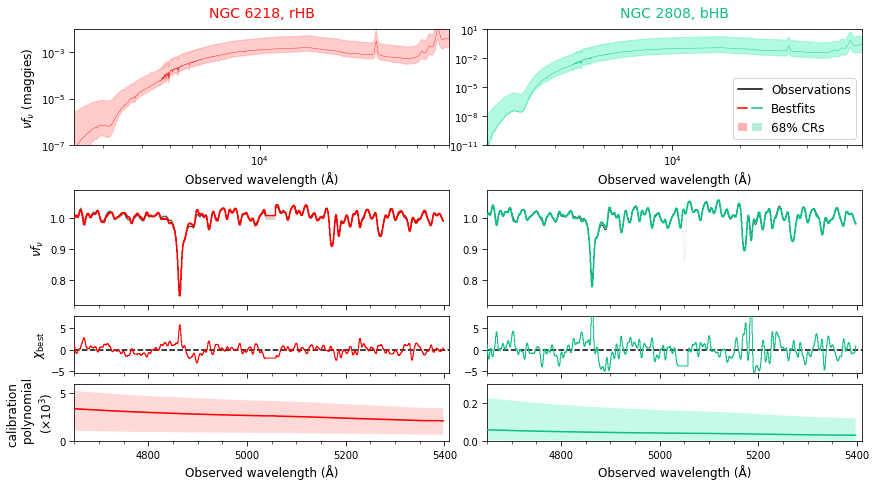

In [6]:
#  just one

spec_xlim = (4650,5410)
hratios, hmult = [2.,0,  0.25,  2.,1,1], 0.4

fig, axs = plt.subplots(6,2, figsize=( fig_width_two, hmult*textheight ), \
                            gridspec_kw={'height_ratios':hratios}, sharex=False)

for iii,params in enumerate([ params1,params2 ]):

    ax1,ax2,axx,ax3,ax4,ax5 = axs[:,iii]
    axx.axis('off')

    plot_fits( [ax1,ax2,axx,ax3,ax4,ax5], lw_bf=1.5, spec_xlim=spec_xlim, norm_cal=1e3, **params )

    if True:

        for ax in [ax3,ax4,ax5]:    
            ax.xaxis.set_minor_locator(ticker.MultipleLocator( 50 ))
            ax.xaxis.set_major_locator(ticker.MultipleLocator( 200 ))
            ax.tick_params(direction='out', length=5, which='major')
            ax.tick_params(direction='out', length=3, which='minor')

        for ax in [ax1,ax2]:    
            ax.tick_params(direction='out', length=5, which='major')
            ax.tick_params(direction='out', length=3, which='minor')

    if True: # add chi2 labels:
        params_ann = {"xycoords":"axes fraction", "xy":(0,0), "fontsize":12, "va":"top", "ha":"right"}
        
        result = params['result']

        try:
            spec_bf, phot_bf, sed_bf, speccal_bf = [ np.copy( result['bestfit'][key] ) for key in ['spectrum','photometry','spectrum_div_speccal','speccal']]
        except:
            spec_bf, phot_bf, sed_bf, speccal_bf = [ np.copy( result['bestfit'][key] ) for key in ['spectrum','photometry','speccal']]
            sed_bf = spec_bf / speccal_bf

        x, y, ey, mask = [ np.copy( result['obs'][key] ) for key in [ "phot_wave","maggies","maggies_unc","phot_mask" ]]
        try:
            chi = (y-phot_bf)/ey
            chi_label = r"Bestfit $\chi^2$/N$_\mathrm{phot}$="+"{:.2f}".format( np.sum(chi[mask]**2)/np.sum(mask).astype(float) )
            ax1.annotate(chi_label, xytext=(0.7,0.15), color=col_bf, **params_ann)
        except: pass

        x, y, ey, mask = [ np.copy( result['obs'][key] ) for key in [ "wavelength","spectrum","unc","mask" ]]
        try:
            norm = 1 # 1e-10
            y /= norm
            ey /= norm
            ybf = spec_bf/norm
            chi = (y-ybf)/ey
            chi[~mask] = np.nan
            chi_label = r"Bestfit $\chi^2$/N$_\mathrm{spec}$="+"{:.2f}".format( np.nansum(chi[mask]**2)/np.sum(mask).astype(float) )
            ax3.annotate(chi_label, xytext=(0.99,0.15), color=col_bf, **params_ann)
        except: pass

    if True: # top legend
        
        l1, = ax1.plot([],[], color='k')
        l2, = ax1.plot([],[], color=params['color_bf'])
        l3 = ax1.fill_between([],[], lw=0, color=params['color_bf'], alpha=0.3)
        ax1.legend( [l1,l2,l3], ['Observations','Bestfit',"68% CRs"], numpoints=1, loc=4, markerscale=0.5 )

    annparams = dict( xy=(0,0), va='top', xycoords='axes fraction', fontsize=14)    
    ax1.annotate( params['label'], color=params['color_bf'], xytext=(0.5, 1.2), ha='center', **annparams )

axs[0,0].set_ylim( 1e-7,1e-2)    
axs[0,1].set_ylim( 1e-11,1e1)    
[ ax.set_ylabel('') for ax in axs[:,1] ]
[ ax.set_ylim( 0.72,1.09)  for ax in axs[3,:] ]  
[ ax.set_ylim( -5.5,8 )  for ax in axs[4,:] ]  
axs[5,0].set_ylim( 0,6 )
axs[5,1].set_ylim( 0,0.3 )

if True: # top legend
    
    axs[0,0].get_legend().remove()
    ax = axs[0,1]
    l1, = ax.plot([],[], color='k')
    l2a, = ax.plot([],[], color=params1['color_bf'])
    l2b, = ax.plot([],[], color=params2['color_bf'])
    l3a = ax.fill_between([],[], lw=0, color=params1['color_bf'], alpha=0.3)
    l3b = ax.fill_between([],[], lw=0, color=params2['color_bf'], alpha=0.3)
    ax.legend( [l1,(l2a,l2b),(l3a,l3b)], ['Observations','Bestfits',"68% CRs"], numpoints=1, loc=4,
                   handler_map={tuple: HandlerTuple(ndivide=None)}, markerscale=0.5)#, bbox_to_anchor=[0.8,0.02] )    
    
fig.subplots_adjust( hspace=0.17, wspace=0.1 )    
plt.savefig('figures/figB1a.pdf', **saveparams)
plt.show()

In [7]:
ndraws = int(1e4) # better to have more draws, but takes longer
prior_draws = prospect_io.get_sfh_priors( model1, ndraws )

priors_params={'facecolor':'None', 'edgecolor':'0.3', 'hatch':'//', 'lw':0 }


In [8]:
params1 = dict( result=result1, obs=obs1, color_models='#ff8080', color_bf='r', label=label1)
params2 = dict( result=result2, obs=obs2, color_models='#3FF0B4', color_bf='#0ebe83', label=label2)

params1['prior_draws'] = prior_draws
params1['priors_params'] = priors_params
params1['bestfit_params'] = {'edgecolor': params1['color_bf'], 'facecolor': 'None', 'marker':'o'}
params1['posts_params'] = {'color': params1['color_bf']}

params2['prior_draws'] = prior_draws
params2['bestfit_params'] = {'edgecolor': params2['color_bf'], 'facecolor': 'None', 'marker':'D'}
params2['posts_params'] = {'color': params2['color_bf']}


In [9]:
from prospect.sources.constants import cosmo
# comology used in fitting

<ipython-input-11-bc304a71d71e>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[-1].set_xticklabels( ax_cmf.get_xticks() )


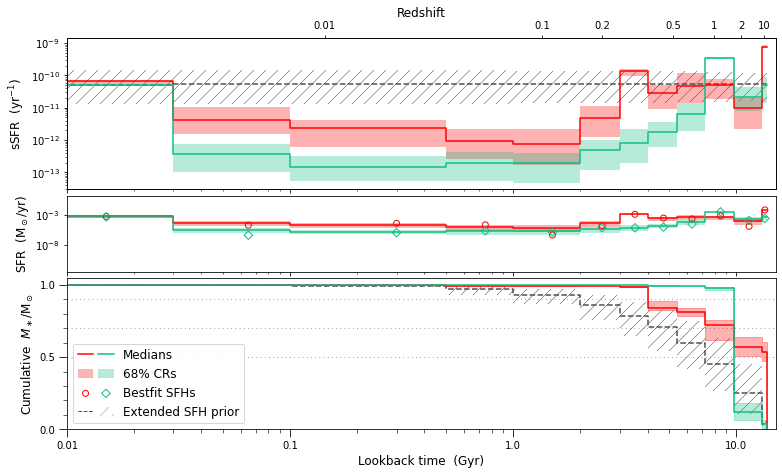

In [11]:
# 
fig, axes = plt.subplots(3,1, 
                         figsize=(fig_width_two*0.9,0.38*textheight), 
                         gridspec_kw={'height_ratios':[2,1,2]}, 
                         sharex=True)
fig.subplots_adjust( wspace=0.05, hspace=0.05 )        
ax_ssfr,ax_sfr,ax_cmf = axes.flatten()


plotting.plot_sfh( ax_ssfr, norm_by_mass=True, show_bestfit=False, show_priors=True, **params1 )
plotting.plot_sfh( ax_ssfr, norm_by_mass=True, show_bestfit=False, show_priors=False, **params2 )

plotting.plot_sfh( ax_sfr, norm_by_mass=False, show_priors=False, **params1 )
plotting.plot_sfh( ax_sfr, norm_by_mass=False, show_priors=False, **params2 )

plotting.plot_cmf( ax_cmf, xscale='linear', style='step', show_bestfit=False, show_priors=True, **params1 )
plotting.plot_cmf( ax_cmf, xscale='linear', style='step', show_bestfit=False, show_priors=False, **params2 )

[ ax.set_xlabel(None) for ax in axes[:-1]]

if True: # axis ticks
    axes[0].set_xscale('log')
    axes[0].set_xlim(0.01, 15 )
    
    ax_sfr.set_ylim(3e-13,2)

    ax_cmf.set_ylim(0,1.05)
    ax_cmf.set_yticks(np.arange(0,1.01,0.5))
    ax_cmf.set_yticks(np.arange(0,1.01,0.1), minor=1)
    for xh in [0.5,0.7,0.9]:
        ax_cmf.axhline( xh, color='0.3', dashes=(1,5), lw=0.7)

    axes[-1].set_xticklabels( ax_cmf.get_xticks() )
    axes[-1].tick_params(direction='out', length=8, which='major')
    axes[-1].tick_params(direction='out', length=4, which='minor')
    
if True: # legend
    ax_legend = axes[-1] 
    
    hist_models_kwargs = {"alpha":0.3, "lw":0}
    hist_prior_kwargs = {"alpha":0.6, "lw":0, "facecolor":"None", }
    line_prior_kwargs = {"alpha":1, "lw":1, "ls":"--"}

#     ax_ssfr.get_legend().remove()
    labels, handles = [],[]
    
    handles.append(( ax_sfr.plot([],[], color=params1['color_bf'],)[0],
                     ax_sfr.plot([],[], color=params2['color_bf'],)[0],
                   )
                  )
    labels.append("Medians" )    
    
    handles.append(( ax_sfr.fill_between([],[], color=params1['color_bf'], **hist_models_kwargs),
                     ax_sfr.fill_between([],[], color=params2['color_bf'], **hist_models_kwargs),
                   )
                  )
    labels.append("68% CRs" )

    handles.append(( ax_sfr.scatter([],[], **params1['bestfit_params'] ),
                     ax_sfr.scatter([],[], **params2['bestfit_params'] ),
                   )
                  )     
    labels.append('Bestfit SFHs' )
    
    handles.append(( ax_sfr.plot([],[], 
                                 color=priors_params['edgecolor'], 
                                 **line_prior_kwargs)[0] ,
                     ax_sfr.fill_between([],[], 
                                         edgecolor=priors_params['edgecolor'], 
                                         hatch=priors_params['hatch'], 
                                         **hist_prior_kwargs), 
                   )
                  )     
    labels.append("Extended SFH prior" )

    ax_legend.legend( handles, labels, numpoints=1, loc=3, ncol=1,
               handler_map={tuple: HandlerTuple(ndivide=None)}, handlelength=3 ) 
    
if True: # top axis    
    zvals = [0.01,0.1,0.2,0.5,1,2,10]
    ages = [cosmo.age(0).value-cosmo.age(z).value for z in zvals]
    tax0 = axes[0].twiny()
    tax0.set_xscale('log')
    tax0.set_xticks(ages)
    tax0.set_xticks([], minor=True)
    tax0.set_xticklabels(zvals)
    tax0.set_xlim(ax_sfr.get_xlim())
    tax0.set_xlabel('Redshift') 

if False: # labels
    xtext, ytext = 1.03, 1
    ax_ann = axes[0]
    annparams = dict( xy=(0,0), va='top', xycoords='axes fraction', fontsize=14)    
    ax_ann.annotate( label0, color='k', xytext=(xtext,ytext), ha='left', **annparams )
    ax_ann.annotate( label1, color=params1['color_bf'], xytext=(xtext,ytext-0.15), ha='left', **annparams )
    ax_ann.annotate( label2, color=params2['color_bf'], xytext=(xtext,ytext-0.3), ha='left', **annparams ) 
    
plt.savefig('figures/figB1b.pdf', **saveparams)
plt.show()

In the cumulative mass panel (third row) shown in Webb+2022, the prior is not properly shown with a log-xscale.
This is corrected here.